# Data path

In [1]:
path = "/home/sravya/data/fisheries/"

# Imports

In [2]:
%matplotlib inline
from theano.sandbox import cuda
#from __future__ import division, print_function

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5103)
/home/sravya/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [4]:
import sys
sys.path.append('../PreTrainedModels')
import vgg16bn; reload(vgg16bn)
from vgg16bn import Vgg16BN

Using Theano backend.


In [5]:
import sys
sys.path.append('../utilities')
import utils; reload(utils)
from utils import *

# Setup data

In [ ]:
#Create required folders


# Create Adapted VGG model with batch normalization

In [6]:
vggbn_model = Vgg16BN(include_top=True)
vggbn_model.ft(8)
vggbn_model.compile()

/home/sravya/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Finetuned for 8 classes.


In [7]:
vggbn_model.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

# Split conv and fc layers

In [8]:
conv_layers, fc_layers = split_at_last(vggbn_model.model, Convolution2D)

In [9]:
#Create conv model from conv layers
conv_model = Sequential(conv_layers)

In [10]:
#Create FC model: 
def get_fc_layers(p, in_shape):
    return [
        MaxPooling2D(input_shape=in_shape),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(8, activation='softmax')
        ]


In [9]:
# TODO - Figure out how to use returned FC layers-> 
# Exception: You are attempting to share a same `BatchNormalization` layer across different data flows. This is not possible. You should use `mode=2` in `BatchNormalization`, which has a similar behavior but is shareable (see docs for a description of the behavior).
# Tried attaching an input layer
# inp = Input(shape=conv_layers[-1].output_shape[1:])
# fc_layers = [inp] + fc_layers
# fc_model = Sequential(fc_layers) -> AttributeError: 'TensorVariable' object has no attribute 'inbound_nodes'
# Tried updating input shape of first layer
# fc_first_layer = fc_layers[0]
# fc_layers=fc_layers[1:]
# fc_first_layer = conv_layers[-1].output_shape[1:] -> same BN exception

In [11]:
layers = get_fc_layers(0.5, conv_layers[-1].output_shape[1:])
fc_model = Sequential(layers)

# Get data, labels and Generate conv features

In [10]:
#Get data as numpy arrays
trn, trn_labels = get_data(path=path+'train')

#TODO: Figure out how can we use batches instead? Advantage: data augmentation?
# Can get features in batches using predict_batches
# trn_features = conv_model.predict_generator(batches, batch_size)
# Can get trn label batches using gen.flow
# trn_label_batches = gen.flow(trn_labels, batch_size=batch_size, shuffle=False)
# How to use fit with feature and label batches?
# fc_model.fit_generator(trn_features, trn_label_batches, nb_epoch = 3, validation_data=(val_features, val_label_batches))

Found 3277 images belonging to 8 classes.


In [11]:
val, val_labels = get_data(path=path+'valid')

Found 500 images belonging to 8 classes.


In [12]:
test, test_labels = get_data(path=path+'test') #ignore test_labels

Found 1000 images belonging to 1 classes.


In [14]:
#Skip if weights exist
trn_feat = conv_model.predict(trn)

In [15]:
val_feat = conv_model.predict(val)
test_feat = conv_model.predict(test)

In [ ]:
save_array(path+'results/conv_feat.dat', feat)
save_array(path+'results/conv_val_feat.dat', val_feat)
save_array(path+'results/conv_test_feat.dat', test_feat)

In [13]:
trn_feat = load_array(path+'results/conv_feat.dat')
val_feat = load_array(path+'results/conv_val_feat.dat')
test_feat = load_array(path+'results/conv_test_feat.dat')
#TODO: Clean up and merge data/results into nbs/results

# Set up infra for observability

In [14]:
# Create a list to hold histories
historyList = list()

In [15]:
#Create a ModelCheckpoint to check point at best val_loss
from keras.callbacks import ModelCheckpoint
def getCheckPoint(file_path):
    checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=0, save_best_only=True)
    return [checkpoint]

In [ ]:
# TODO: Set up Learning rate scheduler? Decay can be set in Adam optimizer but does not seem to be necessary?

# Fit conv features on FC model

In [18]:
fc_model.compile(optimizer=Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [19]:
#Run around 3 epochs before calling ModelCheckPoint call back
historyList.append(fc_model.fit(trn_feat, trn_labels, nb_epoch = 1, validation_data=(val_feat, val_labels)))

Train on 3277 samples, validate on 500 samples
Epoch 1/1
3277/3277 [==============================] - 10s - loss: 2.0165 - acc: 0.7061 - val_loss: 1.1125 - val_acc: 0.8820


In [20]:
file_path = path + "results/Exp1{epoch:02d}-{val_acc:.2f}-{val_loss:.2f}.hdf5"
historyList.append(fc_model.fit(trn_feat, trn_labels, nb_epoch = 40, validation_data=(val_feat, val_labels), callbacks=getCheckPoint(file_path)))

Train on 3277 samples, validate on 500 samples
Epoch 1/40
3277/3277 [==============================] - 11s - loss: 0.7201 - acc: 0.9020 - val_loss: 1.1386 - val_acc: 0.8540
Epoch 2/40
3277/3277 [==============================] - 11s - loss: 0.6544 - acc: 0.9194 - val_loss: 0.8667 - val_acc: 0.9160
Epoch 3/40
3277/3277 [==============================] - 11s - loss: 0.5755 - acc: 0.9301 - val_loss: 0.7164 - val_acc: 0.9340
Epoch 4/40
3277/3277 [==============================] - 10s - loss: 0.4155 - acc: 0.9518 - val_loss: 0.8503 - val_acc: 0.9000
Epoch 5/40
3277/3277 [==============================] - 10s - loss: 0.4251 - acc: 0.9558 - val_loss: 1.0961 - val_acc: 0.8900
Epoch 6/40
3277/3277 [==============================] - 11s - loss: 0.3685 - acc: 0.9573 - val_loss: 0.8144 - val_acc: 0.9220
Epoch 7/40
3277/3277 [==============================] - 11s - loss: 0.3673 - acc: 0.9573 - val_loss: 0.8235 - val_acc: 0.9240
Epoch 8/40
3277/3277 [==============================] - 11s - loss: 0.4

# Plot loss and accuracy histories across epochs

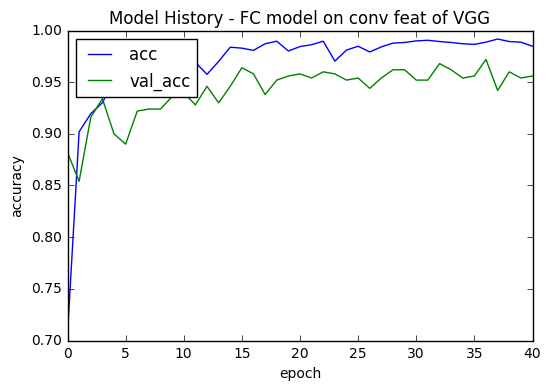

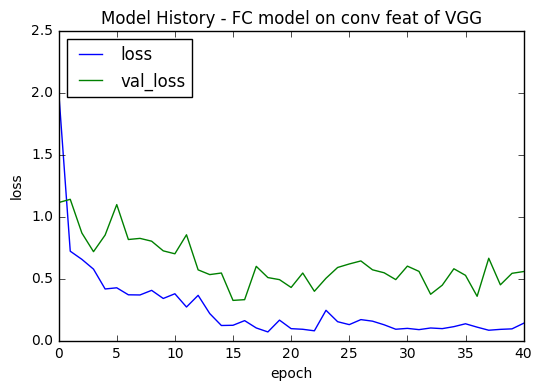

In [23]:
plot_history(historyList,metrics=['acc', 'val_acc'], y_label= "accuracy", model_description='FC model on conv feat of VGG')
plot_history(historyList, metrics=['loss', 'val_loss'], y_label= "loss",model_description='FC model on conv feat of VGG')

# Learning rate annealing

In [26]:
fc_model.load_weights(path +'results/Exp114-0.96-0.32.hdf5')

In [27]:
fc_model.evaluate(val_feat, val_labels)

500/500 [==============================] - 0s     


[0.32342592348531501, 0.96399999999999997]

In [28]:
from keras import backend as K
K.set_value(fc_model.optimizer.lr, 1e-5)

In [29]:
file_path = path + "results/Exp1LR{epoch:02d}-{val_acc:.2f}-{val_loss:.2f}.hdf5"
historyList.append(fc_model.fit(trn_feat, trn_labels, nb_epoch = 20, validation_data=(val_feat, val_labels), callbacks=getCheckPoint(file_path)))

Train on 3277 samples, validate on 500 samples
Epoch 1/20
3277/3277 [==============================] - 12s - loss: 0.0694 - acc: 0.9905 - val_loss: 0.3182 - val_acc: 0.9680
Epoch 2/20
3277/3277 [==============================] - 11s - loss: 0.0668 - acc: 0.9930 - val_loss: 0.3115 - val_acc: 0.9700
Epoch 3/20
3277/3277 [==============================] - 11s - loss: 0.0498 - acc: 0.9927 - val_loss: 0.3081 - val_acc: 0.9700
Epoch 4/20
3277/3277 [==============================] - 10s - loss: 0.0553 - acc: 0.9930 - val_loss: 0.3086 - val_acc: 0.9700
Epoch 5/20
3277/3277 [==============================] - 10s - loss: 0.0488 - acc: 0.9930 - val_loss: 0.3115 - val_acc: 0.9680
Epoch 6/20
3277/3277 [==============================] - 10s - loss: 0.0570 - acc: 0.9942 - val_loss: 0.3145 - val_acc: 0.9700
Epoch 7/20
3277/3277 [==============================] - 10s - loss: 0.0384 - acc: 0.9960 - val_loss: 0.3149 - val_acc: 0.9700
Epoch 8/20
3277/3277 [==============================] - 10s - loss: 0.0

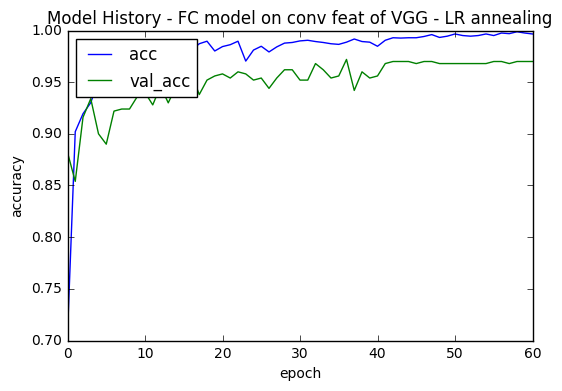

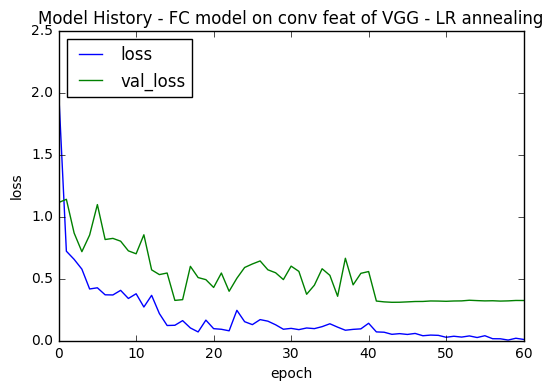

In [30]:
plot_history(historyList,metrics=['acc', 'val_acc'], y_label = 'accuracy', model_description='FC model on conv feat of VGG - LR annealing')
plot_history(historyList,metrics=['loss', 'val_loss'], y_label = 'loss', model_description='FC model on conv feat of VGG - LR annealing')


In [31]:
fc_model.load_weights(path + 'results/Exp1LR02-0.97-0.31.hdf5')

# Use labelled bounding boxes on training set and generate multi output

Labelled data is in the form
{
        "annotations": [
            {
                "class": "rect",
                "height": 65.00000000000023,
                "width": 166.00000000000063,
                "x": 469.00000000000165,
                "y": 448.0000000000016
            },
            {
                "class": "rect",
                "height": 143.0000000000005,
                "width": 98.00000000000036,
                "x": 92.00000000000033,
                "y": 495.00000000000176
            }
        ],
        "class": "image",
        "filename": "img_07915.jpg"
    }
    
Let's pick just the biggest bounding box for each image and create a map of {filename,(height,width,x,y)}

In [43]:
import ujson as json
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']
bb_json = {}
for c in anno_classes:
    j = json.load(open('{}anno/{}_labels.json'.format(path, c), 'r'))
    #Create a map with image name as key and height/width,x,y as values 
    #and ordered by size of the box
    #Note: Some filenames are absolute, so clean them up
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [44]:
bb_json['img_05166.jpg']

{u'class': u'rect',
 u'height': 109.98000000000036,
 u'width': 201.6300000000006,
 u'x': 208.6800000000006,
 u'y': 359.55000000000103}

#### Add empty boxes for images which do not have fishes

In [46]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [47]:
# Get the actual file name
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

In [48]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

#### Resize bb and adjust x, y, height and width as we are using 224x224 images

In [49]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]

In [50]:
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
#val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))

In [51]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params] #TODO: This is not necessary
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [52]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

## Create model with multiple outputs and fit

In [53]:
#MaxP+BN+ DO+Flat+Dense+ (BN+DO+Dense)+(BN+DO+Dense(box)+Dense(fish))
p=0.5
inp = Input(shape=conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization(axis=1)(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization(axis=1)(x)
x = Dropout(p)(x)
x_bb = Dense(4, name='bb')(x)
x_fish = Dense(8, activation='softmax')(x)

In [54]:
model = Model([inp], [x_bb, x_fish])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

In [166]:
batch_size=64
historyList = list()
file_path = path + "results/Exp2{epoch:02d}-{bb_acc:.2f}-{val_loss:.2f}.hdf5"
historyList.append(model.fit(trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=20, 
             validation_data=(val_feat, [val_bbox, val_labels]), callbacks = getCheckPoint(file_path)))

Train on 3277 samples, validate on 500 samples
Epoch 1/20
3277/3277 [==============================] - 2s - loss: 0.1564 - bb_loss: 148.9554 - dense_19_loss: 0.0075 - bb_acc: 0.8142 - dense_19_acc: 0.9973 - val_loss: 0.5360 - val_bb_loss: 297.0171 - val_dense_19_loss: 0.2390 - val_bb_acc: 0.7780 - val_dense_19_acc: 0.9680
Epoch 2/20
3277/3277 [==============================] - 2s - loss: 0.1330 - bb_loss: 130.0937 - dense_19_loss: 0.0029 - bb_acc: 0.8172 - dense_19_acc: 0.9994 - val_loss: 0.5279 - val_bb_loss: 293.7479 - val_dense_19_loss: 0.2342 - val_bb_acc: 0.7840 - val_dense_19_acc: 0.9660
Epoch 3/20
3277/3277 [==============================] - 1s - loss: 0.1410 - bb_loss: 135.7692 - dense_19_loss: 0.0052 - bb_acc: 0.8102 - dense_19_acc: 0.9985 - val_loss: 0.5347 - val_bb_loss: 293.1292 - val_dense_19_loss: 0.2416 - val_bb_acc: 0.7880 - val_dense_19_acc: 0.9660
Epoch 4/20
3277/3277 [==============================] - 2s - loss: 0.1438 - bb_loss: 133.6523 - dense_19_loss: 0.0101 - bb

In [184]:
historyList[0].history['val_bb_loss'] = [x * 0.001 for x in historyList[0].history['val_bb_loss']]

In [185]:
historyList[0].history['bb_loss'] = [x * 0.001 for x in historyList[0].history['val_bb_loss']]

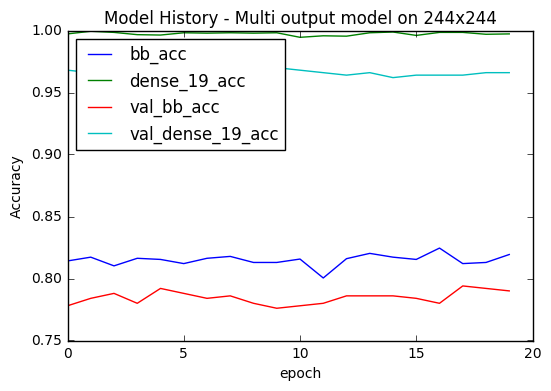

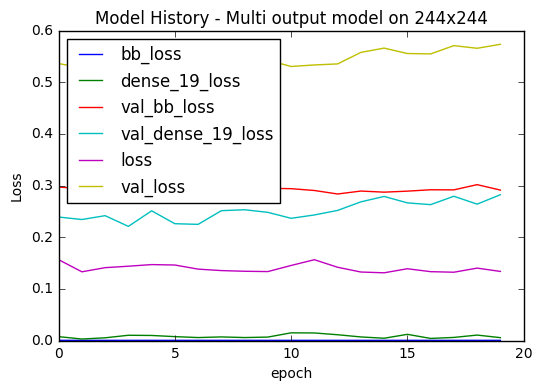

In [186]:
metrics = ['bb_acc', 'dense_19_acc', 'val_bb_acc', 'val_dense_19_acc']
plot_history(historyList, metrics, 'Accuracy', model_description='Multi output model on 244x244')
metrics = ['bb_loss', 'dense_19_loss', 'val_bb_loss', 'val_dense_19_loss', 'loss', 'val_loss']
plot_history(historyList, metrics, 'Loss', model_description='Multi output model on 244x244')

In [55]:
model.load_weights(path + 'results/Exp203-0.82-0.51.hdf5')

In [58]:
batch_size = 64

In [56]:
from keras import backend as K
K.set_value(model.optimizer.lr, 1e-5)

In [59]:
historyList = list()
file_path = path + "results/Exp2LR{epoch:02d}-{bb_acc:.2f}-{val_loss:.2f}.hdf5"
historyList.append(model.fit(trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10, 
             validation_data=(val_feat, [val_bbox, val_labels]), callbacks = getCheckPoint(file_path)))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 2s - loss: 0.1371 - bb_loss: 132.9102 - dense_10_loss: 0.0042 - bb_acc: 0.8169 - dense_10_acc: 0.9991 - val_loss: 0.5109 - val_bb_loss: 291.1710 - val_dense_10_loss: 0.2198 - val_bb_acc: 0.7800 - val_dense_10_acc: 0.9660
Epoch 2/10
3277/3277 [==============================] - 1s - loss: 0.1436 - bb_loss: 134.7008 - dense_10_loss: 0.0089 - bb_acc: 0.8126 - dense_10_acc: 0.9969 - val_loss: 0.5119 - val_bb_loss: 291.4037 - val_dense_10_loss: 0.2205 - val_bb_acc: 0.7820 - val_dense_10_acc: 0.9660
Epoch 3/10
3277/3277 [==============================] - 2s - loss: 0.1496 - bb_loss: 143.9690 - dense_10_loss: 0.0057 - bb_acc: 0.8175 - dense_10_acc: 0.9991 - val_loss: 0.5106 - val_bb_loss: 290.5811 - val_dense_10_loss: 0.2200 - val_bb_acc: 0.7800 - val_dense_10_acc: 0.9660
Epoch 4/10
3277/3277 [==============================] - 1s - loss: 0.1365 - bb_loss: 130.5045 - dense_10_loss: 0.0060 - bb

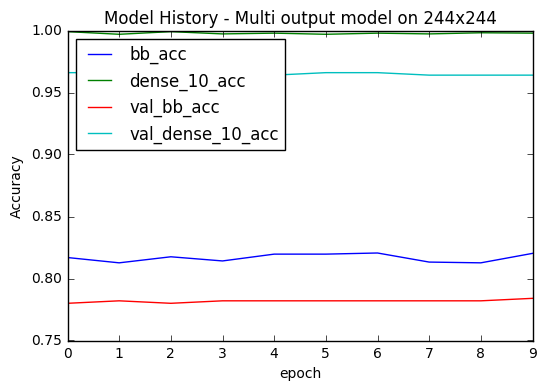

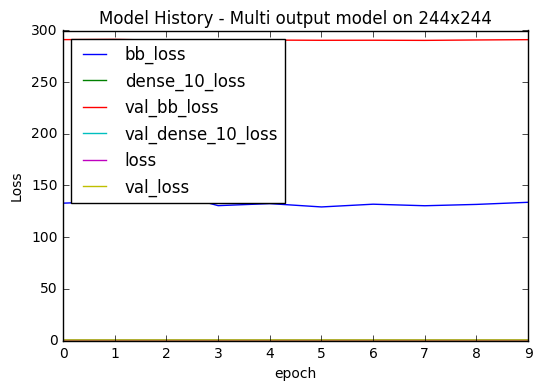

In [62]:
metrics = ['bb_acc', 'dense_10_acc', 'val_bb_acc', 'val_dense_10_acc']
plot_history(historyList, metrics, 'Accuracy', model_description='Multi output model on 244x244')
metrics = ['bb_loss', 'dense_10_loss', 'val_bb_loss', 'val_dense_10_loss', 'loss', 'val_loss']
plot_history(historyList, metrics, 'Loss', model_description='Multi output model on 244x244')

In [34]:
batch_size = 64
preds = fc_model.predict(test_feat, batch_size=batch_size)

In [35]:
subm = do_clip(preds,0.90)
subm_name = path+'kaggle_submissions/lr.gz'    

In [36]:
# classes = sorted(batches.class_indices, key=batches.class_indices.get)
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [39]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [40]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_06237.jpg,0.483632,0.110827,0.066678,0.066678,0.066678,0.066678,0.066678,0.072153
1,img_06893.jpg,0.562500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500
2,img_02082.jpg,0.062514,0.062514,0.062514,0.062514,0.562401,0.062514,0.062514,0.062514
3,img_06261.jpg,0.562500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500
4,img_03628.jpg,0.562500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500


In [41]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [42]:
FileLink(subm_name)

/home/ubuntu/data/fisheries/kaggle_submissions/lr.gz

# Generate bounding boxes on test data

In [197]:
preds = model.predict(test_feat, batch_size=batch_size)

In [198]:
#coordinates
preds[0] 

array([[  35.4092,   21.2392,  126.7818,  109.2504],
       [  24.1813,   21.918 ,   61.4762,  125.7888],
       [  23.1997,   26.2365,   22.1444,   19.5472],
       ..., 
       [  29.5697,   30.5017,   66.7972,  114.1789],
       [  44.0163,   22.7793,  118.1534,  115.2253],
       [  28.7545,   29.8356,   70.5784,  119.0125]], dtype=float32)

## Visualize bounding boxes on test data

### Bounding box on resized image

In [210]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=1)

def show_bb(i):
    bb = preds[0][i]
    plot(test[i])
    plt.gca().add_patch(create_rect(bb))

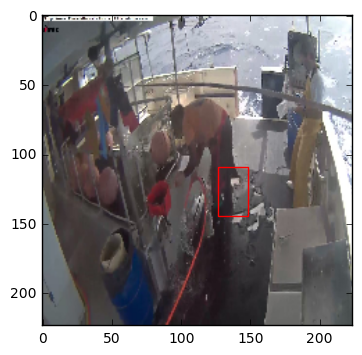

In [211]:
show_bb(0)

#### Show it as Pillow image

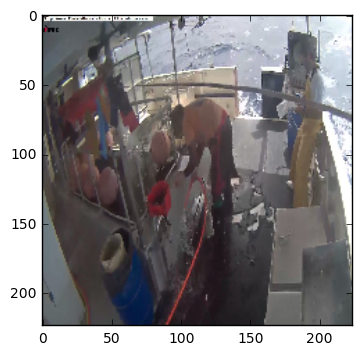

In [223]:
image_data = np.dstack(test[0]).astype('uint8')
pillow_image = Image.fromarray(image_data)
imshow(np.asarray(pillow_image))

### Original image

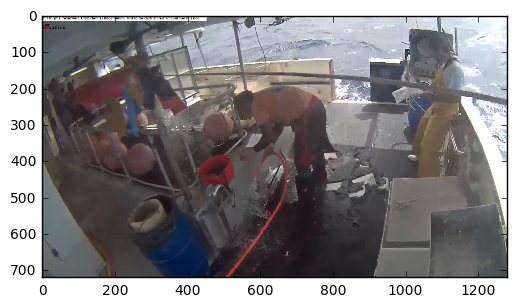

In [227]:
img = Image.open(path + 'test/' + test_filenames[0])
imshow(np.asarray(img))

In [228]:
sample = test[:1]

In [260]:
# Save cropped test images
bad_bb_test = list()
for idx,val in enumerate(test):    
    image_data = np.dstack(val).astype('uint8')
    img = Image.fromarray(image_data)
    cropped_path = path + 'cropped/test/' + test_filenames[idx]
    try:
        img.crop((preds[0][idx][2], preds[0][idx][3], preds[0][idx][2] + preds[0][idx][1], preds[0][idx][3] + preds[0][idx][0])).save(cropped_path)
    except:
        bad_bb_test.append(test_filenames[idx])

In [231]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
classes[0]

'ALB'

In [240]:
trn_classes

array([0, 0, 0, ..., 7, 7, 7], dtype=int32)

In [241]:
classes[trn_classes[2000]]

'NoF'

In [245]:
filenames[0]

'ALB/img_07418.jpg'

In [248]:
sample = val_bbox[:1]

In [257]:
# Save cropped train images
bad_bb_train = list()
for idx,val in enumerate(trn_bbox):    
    print 'Handling idx = ' + str(idx)
    image_data = np.dstack(val).astype('uint8')
    img = Image.fromarray(image_data)
    cropped_path = path + 'cropped/train/' + filenames[idx]
    try:
        img.crop((preds[0][idx][2], preds[0][idx][3], preds[0][idx][2] + preds[0][idx][1], preds[0][idx][3] + preds[0][idx][0])).save(cropped_path)
    except:
        bad_bb_train.append(filenames[idx])

Handling idx = 0
Handling idx = 1
Handling idx = 2
Handling idx = 3
Handling idx = 4
Handling idx = 5
Handling idx = 6
Handling idx = 7
Handling idx = 8
Handling idx = 9
Handling idx = 10
Handling idx = 11
Handling idx = 12
Handling idx = 13
Handling idx = 14
Handling idx = 15
Handling idx = 16
Handling idx = 17
Handling idx = 18
Handling idx = 19
Handling idx = 20
Handling idx = 21
Handling idx = 22
Handling idx = 23
Handling idx = 24
Handling idx = 25
Handling idx = 26
Handling idx = 27
Handling idx = 28
Handling idx = 29
Handling idx = 30
Handling idx = 31
Handling idx = 32
Handling idx = 33
Handling idx = 34
Handling idx = 35
Handling idx = 36
Handling idx = 37
Handling idx = 38
Handling idx = 39
Handling idx = 40
Handling idx = 41
Handling idx = 42
Handling idx = 43
Handling idx = 44
Handling idx = 45
Handling idx = 46
Handling idx = 47
Handling idx = 48
Handling idx = 49
Handling idx = 50
Handling idx = 51
Handling idx = 52
Handling idx = 53
Handling idx = 54
Handling idx = 55
Ha

In [258]:
# Save cropped validation images
bad_bb_valid = list()
for idx,val in enumerate(val_bbox):    
    image_data = np.dstack(val).astype('uint8')
    img = Image.fromarray(image_data)
    cropped_path = path + 'cropped/valid/' + val_filenames[idx]
    try:
        img.crop((preds[0][idx][2], preds[0][idx][3], preds[0][idx][2] + preds[0][idx][1], preds[0][idx][3] + preds[0][idx][0])).save(cropped_path)
    except:
        bad_bb_valid.append(val_filenames[idx])

In [203]:
subm_name = '/home/ubuntu/DL/img2.jpg'
FileLink(subm_name)

/home/ubuntu/DL/img2.jpg

In [ ]:
# Save cropped images

In [261]:
bad_bb_train_file = open(path + 'cropped/bad_bb_train.txt', 'w')
bad_bb_valid_file = open(path + 'cropped/bad_bb_valid.txt', 'w')
bad_bb_test_file = open(path + 'cropped/bad_bb_test.txt', 'w')

In [262]:
for item in bad_bb_train:
  bad_bb_train_file.write("%s\n" % item)
for item in bad_bb_valid:
  bad_bb_valid_file.write("%s\n" % item)
for item in bad_bb_test:
  bad_bb_test_file.write("%s\n" % item)

In [263]:
bad_bb_train_file.close()
bad_bb_valid_file.close()
bad_bb_test_file.close()